In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point, Polygon

%matplotlib inline 


In [2]:
df = pd.read_csv('./NYPD_Complaint_Map__Year_to_Date_.csv')

In [3]:
df2 = pd.read_csv('./NYPD_Complaint_Data_Current_YTD.csv')

In [4]:
df_3 = pd.read_csv('./temp.csv')

In [5]:
df_3.head()

,id,timestamp,lon,lat,tweet,user_id,rtwts,fvrts,application,source
0,767446336819957760,1471822839,40.574567,-73.980458,Yesterday's Video Shoot For #BEENON Dropping S...,213162943,0,0,Instagram,CUSP2_2016-08-21 15:43
1,767446493091467264,1471822877,40.572950,-73.987450,@dibellaent action begins live at the fordampc...,75603452,0,0,Instagram,CUSP2_2016-08-21 15:43
2,767446529061912576,1471822885,40.655670,-74.006943,#salsadancing with @mhernandez8444 @ Industry ...,204875947,0,0,Instagram,CUSP2_2016-08-21 15:43
3,767446726047301633,1471822932,40.589544,-74.065854,Ainda em NYC. @ South Beach at Staten Is. NY h...,23276698,0,0,Instagram,CUSP2_2016-08-21 15:43
4,767446834935689218,1471822958,40.690019,-74.187507,Ya quiero salir de acá. (@ National Car Rental...,377058948,0,0,Foursquare,CUSP2_2016-08-21 15:43


In [6]:
df_3['date']= pd.to_datetime(df_3['timestamp'].astype(int), unit='s')

In [7]:
df_3['month'] = df_3['date'].dt.month

In [8]:
df_3.groupby('month').count()

,id,timestamp,lon,lat,tweet,user_id,rtwts,fvrts,application,source,date
month,,,,,,,,,,,
8,59546,59546,59546,59546,59546,59546,59546,59546,59546,59546,59546
9,190469,190469,190469,190469,190469,190469,190469,190469,190469,190469,190469
11,26107,26107,26107,26107,26107,26107,26107,26107,26107,26107,26107


In [9]:
df_4 = df_3.drop(["application", "source", 'timestamp'],1)

In [10]:
from textblob import TextBlob
def tweetTosentiment(tweets):
    try:
        text_blob = TextBlob(tweets)
        sentiment = text_blob.sentiment
        result = sentiment.polarity
    except:
        result = np.nan
    
    return result

In [11]:
df_3['polarity'] = df_3['tweet'].apply(tweetTosentiment)

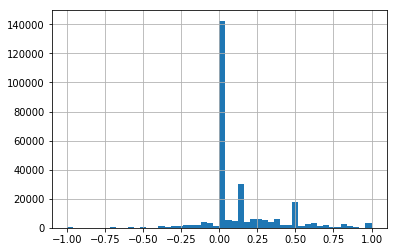

In [12]:
df_3['polarity'].hist(bins=50)

In [13]:
zipcode = gp.read_file('./ZIP_CODE_040114/ZIP_CODE_040114.shp')

In [14]:
zipcode = zipcode.to_crs(epsg=4326)[["POPULATION","ZIPCODE", 'geometry']]

In [15]:
police_pricint = gp.read_file('./nypp_17b/nypp.shp')

In [16]:
police_pricint = police_pricint.to_crs(epsg=4326)

In [21]:
geometry = [Point(xy) for xy in zip(df_3.lat, df_3.lon)]
crs = {'init': 'epsg:4326'}
geo_df = gp.GeoDataFrame(df_3, crs=crs, geometry=geometry)

In [22]:
result = gp.sjoin(geo_df, police_pricint, how="inner", op='within')

In [23]:
df_3.shape[0] - result.shape[0]

35221

In [24]:
result['date_h']= result['date'].dt.strftime("%Y-%m-%d %H")

In [25]:
#c = pd.DataFrame(result.groupby(['ZIPCODE', 'date_h'])['tweet'].apply(list))
c = pd.DataFrame(result.groupby(['Precinct', 'date_h'])['tweet'].apply(list))

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 100

def tfidf(tweet):  
    # NMF is able to use tf-idf
    tfidf_vectorizer = TfidfVectorizer(max_df=1, min_df=0., 
                                       max_features=no_features, 
                                       stop_words='english')
    try:
        return tfidf_vectorizer.fit_transform(tweet)
    except:
        return np.nan

c['tfidf'] = c['tweet'].apply(tfidf)
#tfidf = tfidf_vectorizer.fit_transform(documents)
#tfidf_feature_names = tfidf_vectorizer.get_feature_names()
def tf(tweet):  
    # NMF is able to use tf-idf
    tf_vectorizer = CountVectorizer(max_df=1, min_df=0, 
                                   max_features=no_features, 
                                    stop_words='english')
    try:
        return tf_vectorizer.fit_transform(tweet)
    except:
        return np.nan


# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
c['tf'] = c['tweet'].apply(tf)
#tf_feature_names = tf_vectorizer.get_feature_names()


In [27]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 5


def nmf(tfidf):  
    # NMF is able to use tf-idf
    nmf_fit = NMF(n_components=no_topics, 
                                random_state=1, 
                                alpha=.1, 
                                l1_ratio=.5, init='nndsvd')
    try:
        return nmf_fit.fit_transform(tf)
    except:
        return np.nan
    
def lda(tf):  
    # NMF is able to use tf-idf
    lda_fit = LatentDirichletAllocation(n_topics=no_topics, 
                                        max_iter=5, 
                                        learning_method='online', 
                                        learning_offset=50.,
                                        random_state=0)
    try:
        return lda_fit.fit_transform(tf).mean(axis=0)
    except:
        return np.nan


In [28]:
# Run NMF
c['nmf'] = c['tfidf'].apply(nmf)
# # Run LDA
# #lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
c['lda'] = c['tf'].apply(lda)

In [111]:
result.head()

,id,timestamp,lon,lat,tweet,user_id,rtwts,fvrts,application,source,date,month,polarity,geometry,index_right,Precinct,Shape_Area,Shape_Leng,date_h
0,767446336819957760,1471822839,40.574567,-73.980458,Yesterday's Video Shoot For #BEENON Dropping S...,213162943,0,0,Instagram,CUSP2_2016-08-21 15:43,2016-08-21 23:40:39,8,0.000000,POINT (-73.98045807 40.5745674),34,60,8.816956e+07,66157.635733,2016-08-21 23
1,767446493091467264,1471822877,40.572950,-73.987450,@dibellaent action begins live at the fordampc...,75603452,0,0,Instagram,CUSP2_2016-08-21 15:43,2016-08-21 23:41:17,8,0.124242,POINT (-73.98745 40.57295),34,60,8.816956e+07,66157.635733,2016-08-21 23
64,767449996740337664,1471823712,40.572950,-73.987450,Far Rock's Joseph Williams is putting in work ...,428659031,0,0,Instagram,CUSP2_2016-08-21 15:43,2016-08-21 23:55:12,8,0.100000,POINT (-73.98745 40.57295),34,60,8.816956e+07,66157.635733,2016-08-21 23
114,767451293673721856,1471824021,40.572950,-73.987450,Having fun with the girls! lilgladiator #pbcbo...,24374586,1,1,Instagram,CUSP2_2016-08-21 16:00,2016-08-22 00:00:21,8,0.375000,POINT (-73.98745 40.57295),34,60,8.816956e+07,66157.635733,2016-08-22 00
166,767454152972652544,1471824703,40.572950,-73.987450,@jmackwilliams scores a 6 round ud decision 60...,600449920,0,0,Instagram,CUSP2_2016-08-21 16:00,2016-08-22 00:11:43,8,-0.200000,POINT (-73.98745 40.57295),34,60,8.816956e+07,66157.635733,2016-08-22 00


In [112]:
sentiment_retweet = pd.DataFrame(result.groupby(['Precinct','date_h'])['polarity', 'rtwts', 'fvrts'].mean())

In [113]:
tweet_counts = pd.DataFrame(result.groupby(['Precinct','date_h']).size())

In [29]:
import pickle
pickle.dump(c, open('c_frame.pkl','wb'))
tweet_counts = pickle.load(open('tweet_counts_2.pkl', 'rb'))
sentiment_retweet = pickle.load(open('sentiment_retweet_2.pkl', 'rb'))

In [30]:
new_frame = sentiment_retweet.join(tweet_counts)

In [31]:
new_frame[['topic_{}'.format(i) for i in range(5)]] = c['lda'].apply(pd.Series)

In [32]:
new_frame = new_frame.rename(columns={0:'counts'})

In [33]:
new_frame = new_frame.reset_index()

In [34]:
new_frame['date_h'] = new_frame['date_h'].apply(pd.to_datetime)
new_frame['dayofweek'] = new_frame['date_h'].dt.dayofweek
new_frame['month'] = new_frame['date_h'].dt.month
new_frame['hour'] = new_frame['date_h'].dt.hour

In [35]:
new_frame = new_frame.sort_values(by='date_h')

In [40]:
new_frame.Precinct.unique()

array([  1, 102,  19, 104,  18,  17, 107, 108,  14, 109,  13,  10, 114,
       115,   6,   5, 101, 122, 100,  22,  43,  47,  40,  60,  34,  67,
        32,  68,  72,  28,  75,  77,  78,  83,  23,  94, 123,  90,  45,
        79,  25,  26,  30,  66,  33,  62,  61,  52,  50,  41,  49,  42,
        48,  81,  24,  84,   9, 113, 112, 111, 110, 105, 121, 103,  20,
       106,  46,  44,  63,  73, 120,  88,  69,   7,  70,  76,  71])

In [37]:
x_train = new_frame[new_frame['month'] != 11]
x_test = new_frame[new_frame['month'] == 11]

In [44]:
crime = pd.read_csv('./NYPD_Complaint_Data_Current_YTD.csv')
crime['date_h'] = crime['CMPLNT_TO_DT'] + " " +  crime['CMPLNT_TO_TM']
crime['date_h'] = pd.to_datetime(crime['date_h'], format="%m/%d/%Y %H:%M:%S", errors='coerce')
#crime = crime.sort_values(by='date_h')

In [45]:
crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,date_h
0,845348933,03/31/2017,23:30:00,NaN,NaN,03/31/2017,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1012423.0,171737.0,40.638018,-73.898491,"(40.638018389, -73.898491201)",NaT
1,886921338,03/31/2017,23:25:00,03/31/2017,23:30:00,03/31/2017,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,NaN,STREET,NaN,NaN,987466.0,215861.0,40.759173,-73.988393,"(40.759172699, -73.988392793)",2017-03-31 23:30:00
2,893265998,03/31/2017,23:15:00,03/31/2017,23:25:00,03/31/2017,105,ROBBERY,394.0,"ROBBERY,LICENSED FOR HIRE VEHICLE",...,FRONT OF,TAXI (LIVERY LICENSED),NaN,NaN,1010502.0,245411.0,40.840241,-73.905125,"(40.84024096, -73.905125257)",2017-03-31 23:25:00
3,518511851,03/31/2017,23:00:00,03/31/2017,23:10:00,03/31/2017,364,OTHER STATE LAWS (NON PENAL LA,809.0,TAX LAW,...,INSIDE,GROCERY/BODEGA,NaN,NaN,1023622.0,253318.0,40.861895,-73.857662,"(40.861894559, -73.85766248)",2017-03-31 23:10:00
4,541009476,03/31/2017,22:55:00,03/31/2017,22:59:00,03/31/2017,235,DANGEROUS DRUGS,511.0,"CONTROLLED SUBSTANCE, POSSESSI",...,FRONT OF,STREET,NaN,NaN,977956.0,167273.0,40.625808,-74.022675,"(40.625808217, -74.022675222)",2017-03-31 22:59:00


In [57]:
crime = crime.dropna(subset=["Latitude", "Longitude"])
geometry = [Point(xy) for xy in zip(crime.Longitude, crime.Latitude)]
crs = {'init': 'epsg:4326'}
crime['geometry'] = geometry
geo_df_crime = gp.GeoDataFrame(crime, crs=crs, geometry=geometry)
result_crime = gp.sjoin(geo_df_crime, police_pricint, how="inner", op='intersects')

In [62]:
crime = result_crime.copy()
crime = crime.sort_values(by='date_h')

In [98]:
from datetime import timedelta
crime['date_h'] = crime['date_h'] - timedelta(hours=1)

In [99]:
crime['month'] = crime['date_h'].dt.month
crime['year'] = crime['date_h'].dt.year

In [100]:
train_target = crime[(crime['year'] == 2016) & ((crime['month']>7) & (crime['month']<10))]
train_crime_counts = pd.DataFrame(train_target.groupby(['Precinct','date_h']).size()).rename(columns={0: 'next_hour_crime'})

In [110]:
test_target = crime[(crime['year'] == 2016) & ((crime['month']==11))]
test_crime_counts = pd.DataFrame(test_target.groupby(['Precinct','date_h']).size()).rename(columns={0: 'next_hour_crime'})
#test_crime_counts = test_crime_counts.sort_values(by='date_h')

In [136]:
train_x = x_train.set_index(['Precinct','date_h']).join(train_crime_counts, how='left').reset_index('Precinct')
test_x = x_test.set_index(['Precinct','date_h']).join(test_crime_counts, how='left').reset_index('Precinct')

In [142]:
train_x['next_hour_crime'] = train_x['next_hour_crime'].apply(lambda x: 1 if x>0 else 0)
train_x[['Precinct','dayofweek', 'month', 'hour']] = train_x[['Precinct','dayofweek', 'month', 'hour']].astype(str)

In [143]:
test_x['next_hour_crime'] = test_x['next_hour_crime'].apply(lambda x: 1 if x>0 else 0)
test_x[['Precinct','dayofweek', 'month', 'hour']] = test_x[['Precinct','dayofweek', 'month', 'hour']].astype(str)

In [150]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
def imputation(X):
    d = defaultdict(LabelEncoder)
    # Encoding the variable 
    X_cat = X[['Precinct','dayofweek', 'month', 'hour']]
    X_cat = X_cat.fillna('NAN')
    X_cat = X_cat.apply(lambda x: d[x.name].fit_transform(x))
    X_float = X[["polarity", "rtwts", "fvrts", "counts", "topic_0", "topic_1","topic_2", "topic_3", "topic_4"]]
    X_float = X_float.fillna(X_float.mean())
    return pd.concat([X_cat, X_float], axis=1)

In [151]:
imputed_x = imputation(train_x.iloc[:,:-1])
Y = train_x.iloc[:,-1]

In [152]:
imputed_x_test = imputation(test_x.iloc[:,:-1])
Y_test = test_x.iloc[:,-1]

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
cv = StratifiedKFold(Y, n_folds=6, random_state=111, shuffle=True)
clf = RandomForestClassifier(random_state=111)
all_im = []
for train, test in cv:
        clf.fit(imputed_x.iloc[train], Y.iloc[train])
        all_im.append(clf.feature_importances_)
        
importance_value = np.average(all_im, axis=0)
importance = pd.DataFrame(importance_value, index=imputed_x.columns.values, 
                          columns=["Importance"])

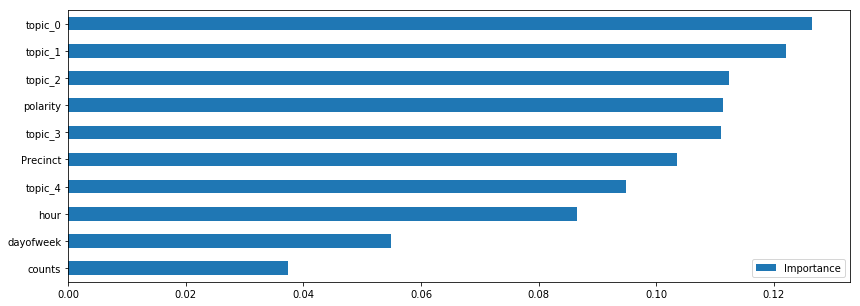

In [154]:
importance.sort_values(by='Importance', ascending=True).tail(10).plot(kind='barh', figsize=(14,5))
plt.show()


In [155]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.set_printoptions(precision=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix

In [156]:
from sklearn.model_selection import cross_val_score
cross_val = cross_val_score(clf, imputed_x, Y, cv=cv)
mean_accuracy = np.mean(cross_val)

print (cross_val, mean_accuracy)

[ 0.99906977  0.99906962  0.99906962  0.99906962  0.99922457  0.99922457] 0.999121294758


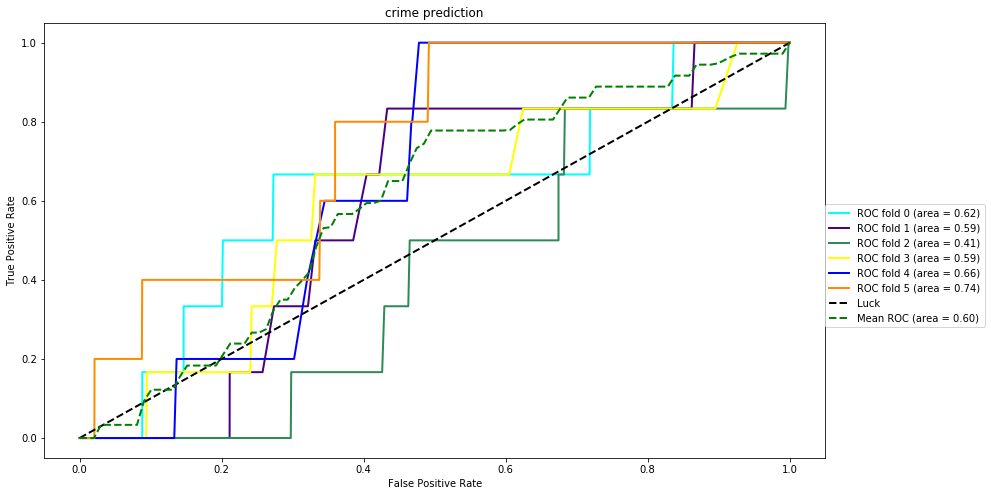

In [169]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Run classifier with cross-validation and plot ROC curves
plt.figure(figsize=(14,8))
classifier = RandomForestClassifier(n_estimators=10, criterion='gini', 
                             max_depth=3, min_samples_split=30, 
                             min_samples_leaf=100,random_state=111)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv, colors):
    probas_ = classifier.fit(imputed_x.iloc[train], Y.iloc[train]).predict_proba(imputed_x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y.iloc[test].apply(int), probas_[:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= 6.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('crime prediction')
plt.legend(loc=[1,0.3])
plt.show()

In [171]:
from sklearn.metrics import confusion_matrix
cnf_matrix=[]
all_im=[]
for (train, test), color in zip(cv, colors):
    y_pred = classifier.fit(imputed_x.iloc[train], Y.iloc[train]).predict(imputed_x.iloc[test])
    all_im.append(classifier.feature_importances_)
    cnf = confusion_matrix(Y.iloc[test], y_pred)
    cnf_matrix.append(cnf)
final_cnf = np.mean(cnf_matrix, axis=0)

In [172]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.set_printoptions(precision=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


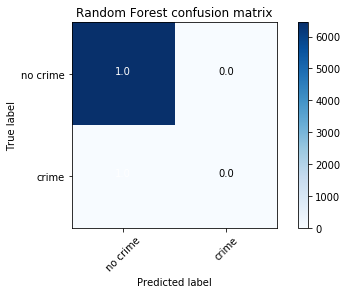

In [173]:
import itertools
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(np.mean(cnf_matrix, axis=0), classes=['NonDATs', 'DATs'],
#                       title='Confusion matrix, without normalization')

cnf_matrix_mean = np.mean(cnf_matrix, axis=0)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_mean, classes=['no crime', 'crime'], normalize=True,
                      title='Random Forest confusion matrix')

plt.show()